In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row

In [2]:
accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_9576\667666233.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_moon = pd.read_csv("../nesrece_lunine_mene_2010_2023.csv")


In [3]:
# Nastavljanje pravilnega časovnega pasu
accidents_moon['NastanekDatumCas'] = pd.to_datetime(accidents_moon['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
accidents_moon['NastanekDatumCas'] = accidents_moon['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {accidents_moon['NastanekDatumCas'].dtype}")
#display(accidents_moon)

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy - prvi krajec

Preverila bom, če se ritmičnost nesreč, ki so se zgodile med prvim krajcem, razlikuje od ritmičnosti ostalih nesreč.

In [ ]:
# Maska za luno
moon_mask = (accidents_moon['moon_phase'] == 'First Quarter')

accidents_first_quarter = accidents_moon[moon_mask]
# display(accidents_first_quarter)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = accidents_first_quarter['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsFirstQ",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

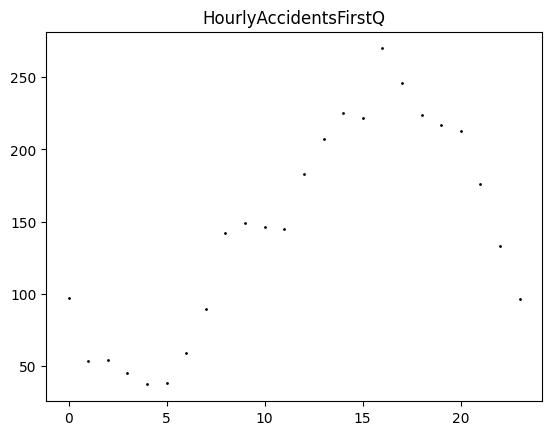

In [5]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsFirstQ"])

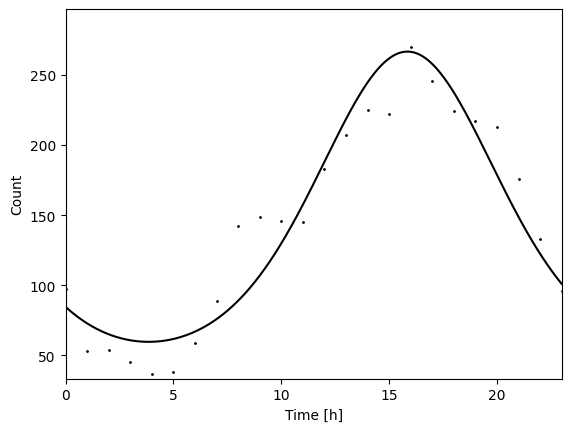

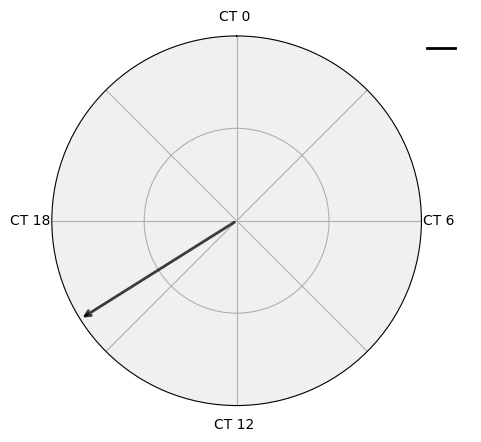

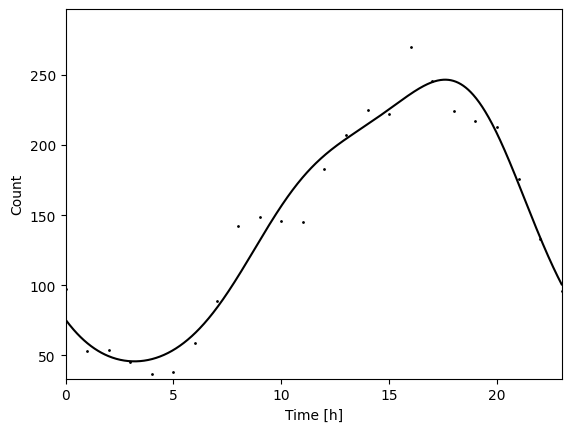

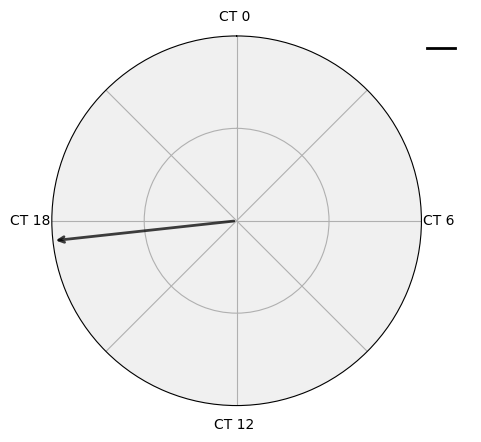

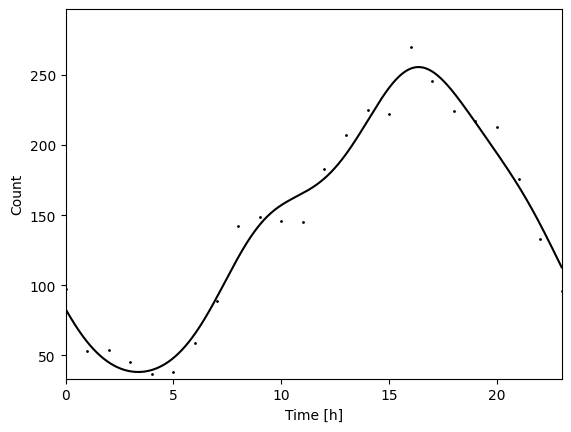

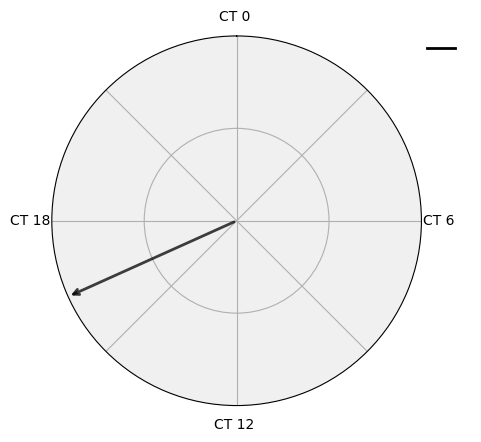

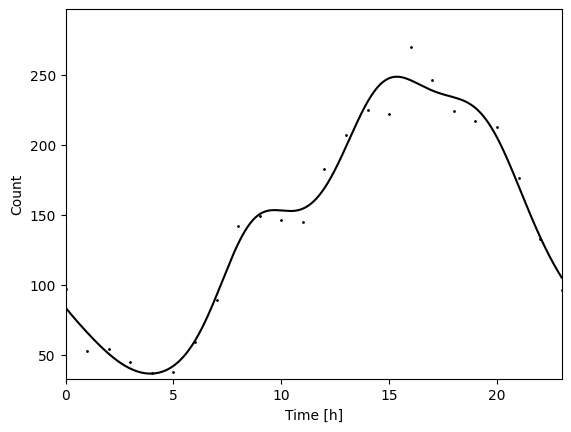

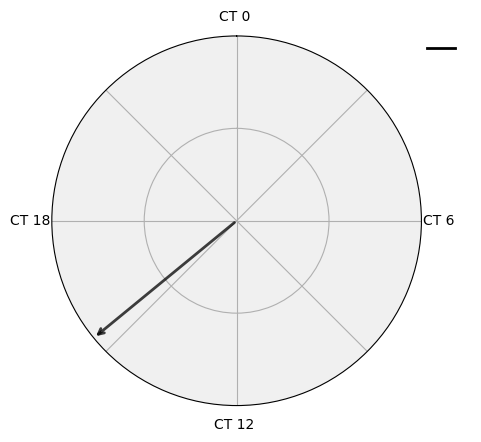

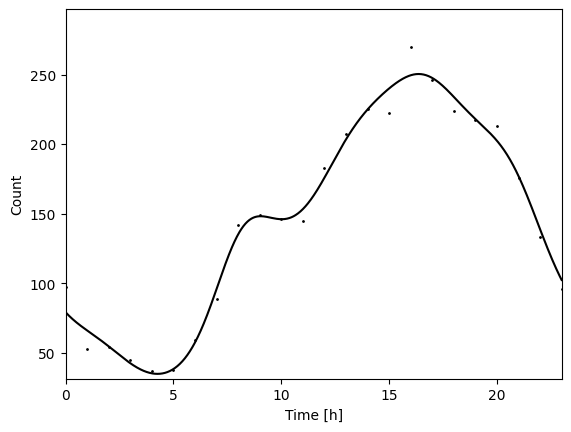

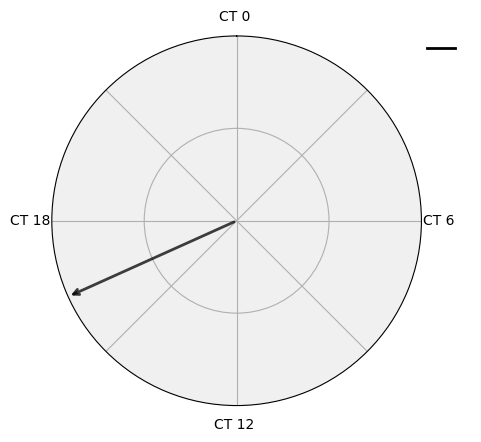

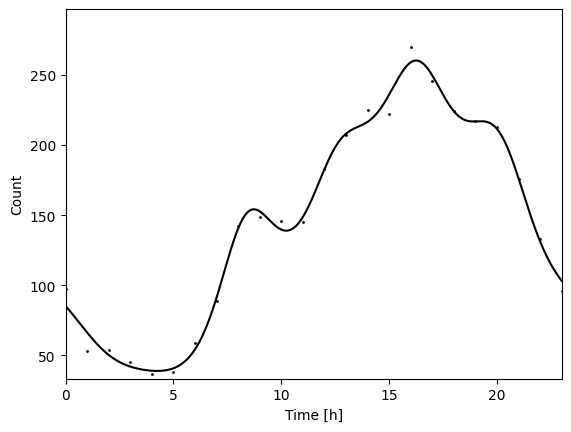

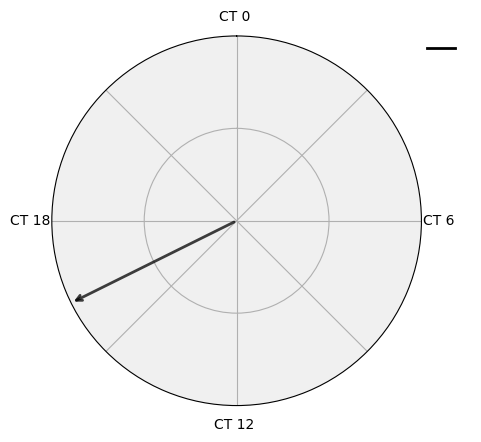

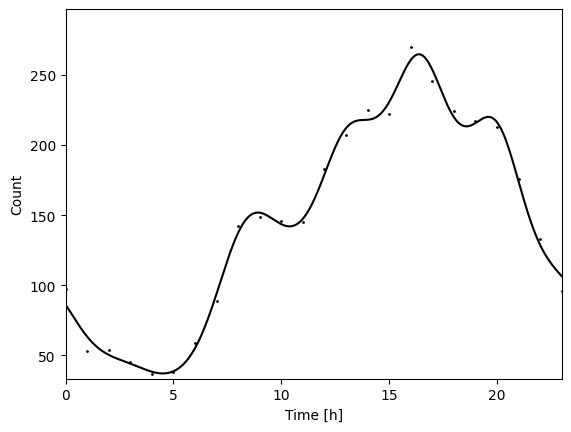

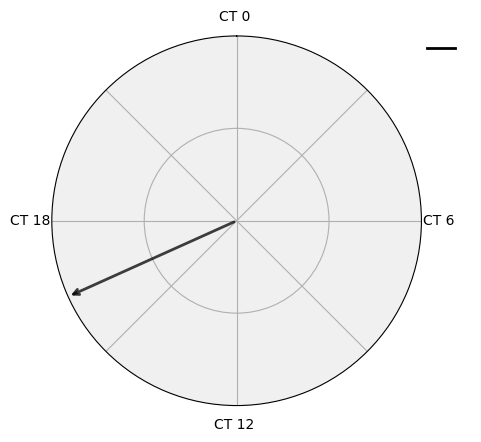

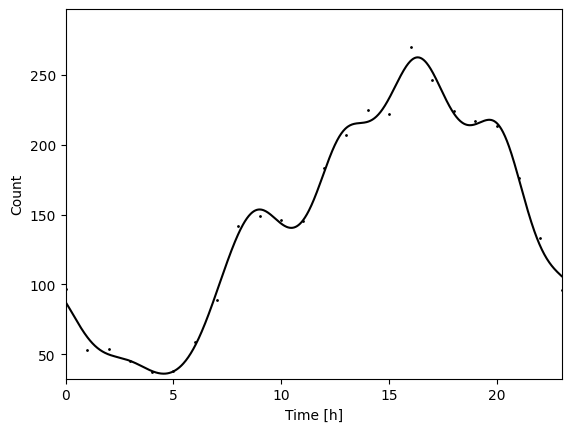

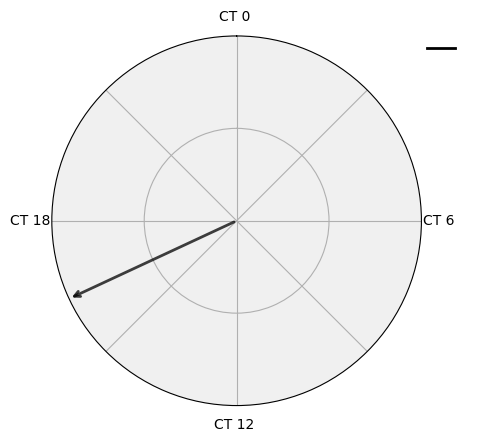

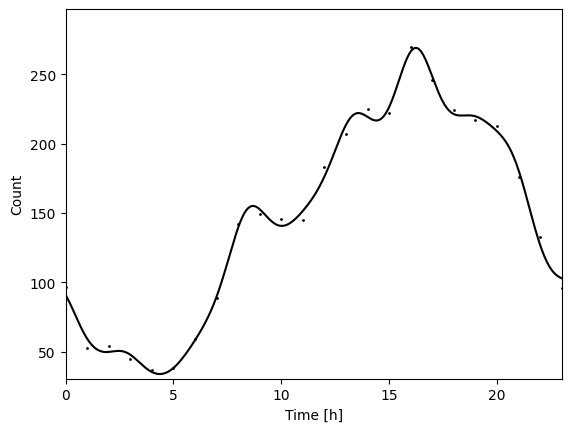

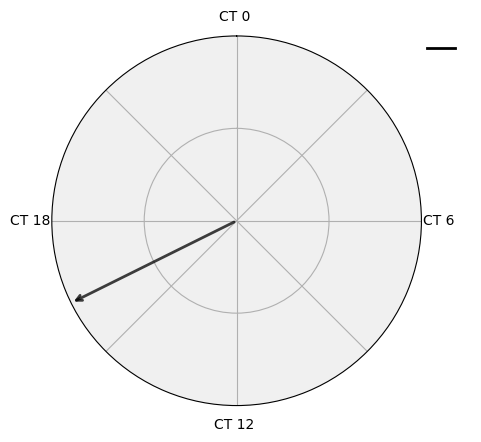

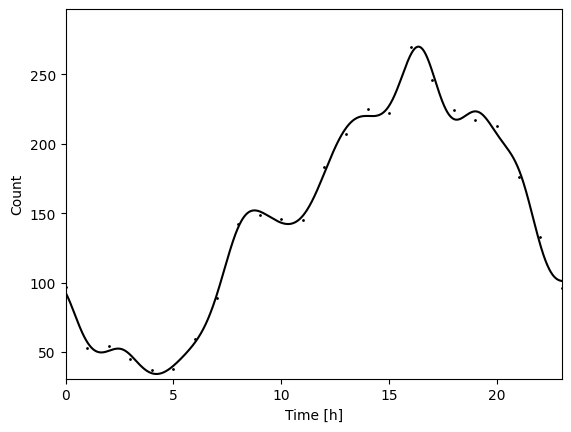

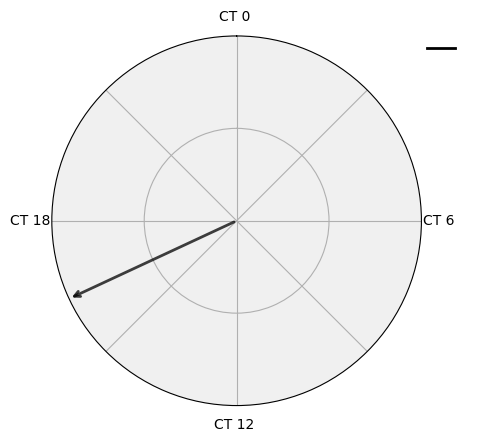

In [6]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsFirstQ', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [7]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsFirstQ,24.0,1.0,3.041127e-13,3.041127e-13,11801.217933,-108.977586,0.209155,103.536537,2.132132,163.159039,[15.855855855855856],[266.6955761318432],[3.843843843843844],[59.62250185692028]
1,HourlyAccidentsFirstQ,24.0,2.0,5.646947e-16,6.274385e-16,5810.167509,-99.005003,0.281526,100.483623,1.679290,146.176349,[17.585585585585587],[246.6599125634087],[3.171171171171171],[45.69380060011807]
2,HourlyAccidentsFirstQ,24.0,3.0,3.742491e-17,4.678114e-17,3477.417571,-93.019781,0.324960,108.776288,1.993764,146.885564,[16.384384384384383],[255.65835944178923],[3.3633633633633635],[38.109275344017284]
3,HourlyAccidentsFirstQ,24.0,4.0,3.801178e-18,5.430255e-18,2643.562685,-87.675617,0.363743,106.080969,2.257921,142.623607,"[9.657657657657657, 15.375375375375375]","[153.37446744345127, 248.70171358143853]",[3.93993993993994],[36.542638073950506]
4,HourlyAccidentsFirstQ,24.0,5.0,2.726334e-18,4.543890e-18,1765.181616,-84.557580,0.386370,107.732821,1.993764,142.642063,"[9.033033033033034, 16.384384384384383]","[148.18638202703457, 250.37277682147115]",[4.276276276276276],[34.91084516133004]
5,HourlyAccidentsFirstQ,24.0,6.0,1.619390e-19,5.397965e-19,905.095985,-78.848959,0.427797,110.746902,2.031500,149.604599,"[8.744744744744745, 16.24024024024024, 19.2672...","[154.17675668249709, 260.35138050435086, 217.0...","[4.228228228228228, 10.234234234234235]","[38.858281072262244, 138.91903403653842]"
6,HourlyAccidentsFirstQ,24.0,7.0,2.257681e-19,5.644202e-19,794.961648,-76.663481,0.443657,113.865790,1.993764,150.922912,"[8.936936936936936, 16.384384384384383, 19.603...","[151.85823481178545, 264.7887015366063, 220.11...","[4.516516516516517, 10.378378378378379]","[37.057122194521696, 142.00836327349137]"
7,HourlyAccidentsFirstQ,24.0,8.0,1.203300e-18,2.406600e-18,810.975100,-76.087188,0.447839,113.203729,2.006342,149.277373,"[8.984984984984985, 16.336336336336338, 19.651...","[153.60383951921676, 262.4797717959284, 217.79...","[4.564564564564565, 10.474474474474475]","[36.07543740726748, 140.43400256802755]"
8,HourlyAccidentsFirstQ,24.0,9.0,6.681349e-20,3.340675e-19,495.794584,-70.447531,0.488766,117.552892,2.031500,151.505170,"[8.696696696696696, 13.597597597597597, 16.240...","[155.0986731340601, 222.0662569708304, 269.058...","[1.8738738738738738, 4.372372372372372, 10.042...","[49.787563081617286, 33.95227774475915, 140.73..."
9,HourlyAccidentsFirstQ,24.0,10.0,6.569876e-20,3.340675e-19,466.104897,-68.097720,0.505818,117.923116,2.006342,152.037273,"[13.933933933933934, 16.336336336336338, 18.97...","[220.02518762455955, 269.93763165820604, 223.3...","[1.6336336336336337, 4.228228228228228, 10.330...","[49.639526701598946, 34.11744512338152, 142.15..."


### Katero je najboljše število komponent

In [8]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsFirstQ,24.0,6.0,1.619390e-19,5.397965e-19,905.095985,-78.848959,0.427797,110.746902,2.0315,149.604599,"[8.744744744744745, 16.24024024024024, 19.2672...","[154.17675668249709, 260.35138050435086, 217.0...","[4.228228228228228, 10.234234234234235]","[38.858281072262244, 138.91903403653842]"


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


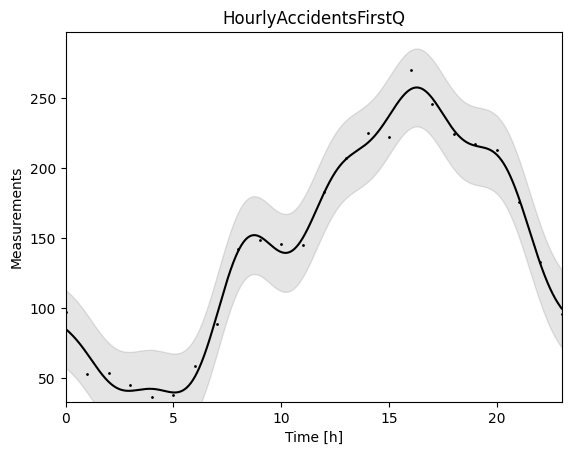

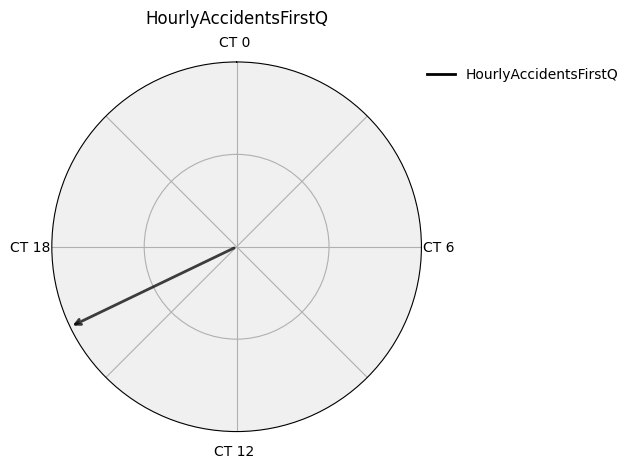

In [9]:
cosinor.plot_df_models(df_plot, df_best_model)